In [1]:
import pandas as pd
import pymysql
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import naive_bayes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import tushare as ts
from snownlp import SnowNLP
import wordcloud
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from sklearn import metrics
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

# 获取股票数据

In [2]:
# 获取京东方A股票的历史行情
# 这个token需要自己到tushare的官网上面去申请，也可以使用这一个
ts.set_token("e3465973d838cdf0ce55a6d614c8a65bc45a2d99653fb87dfd718086")
pro = ts.pro_api()
# 获取每天的行情数据，指定起止日期
df_725 = pro.daily(ts_code='000725.SZ', start_date='20100101', end_date='20191229')
# 将日期转为datetime类型格式
df_725["trade_date"] = pd.to_datetime(df_725["trade_date"])
# 将日期作为索引
df_725 = df_725.set_index("trade_date")
print(df_725.shape)
df_725.head()

(2413, 10)


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2019-12-27,000725.SZ,4.85,4.85,4.61,4.64,4.83,-0.19,-3.9337,11744059.05,5535803.934
2019-12-26,000725.SZ,4.78,4.89,4.73,4.83,4.74,0.09,1.8987,11781181.32,5670161.331
2019-12-25,000725.SZ,4.67,4.78,4.65,4.74,4.70,0.04,0.8511,7946674.08,3740227.994
2019-12-24,000725.SZ,4.60,4.72,4.48,4.70,4.56,0.14,3.0702,9582547.55,4410735.133
2019-12-23,000725.SZ,4.76,4.81,4.54,4.56,4.68,-0.12,-2.5641,11865097.22,5560483.237


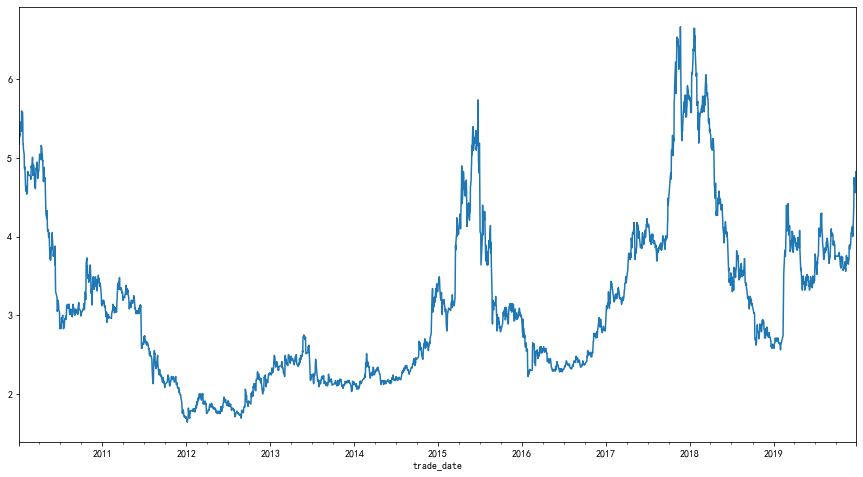

In [3]:
# 展示股票日线
df_725.to_period("D")["close"].plot(figsize=(15, 8))

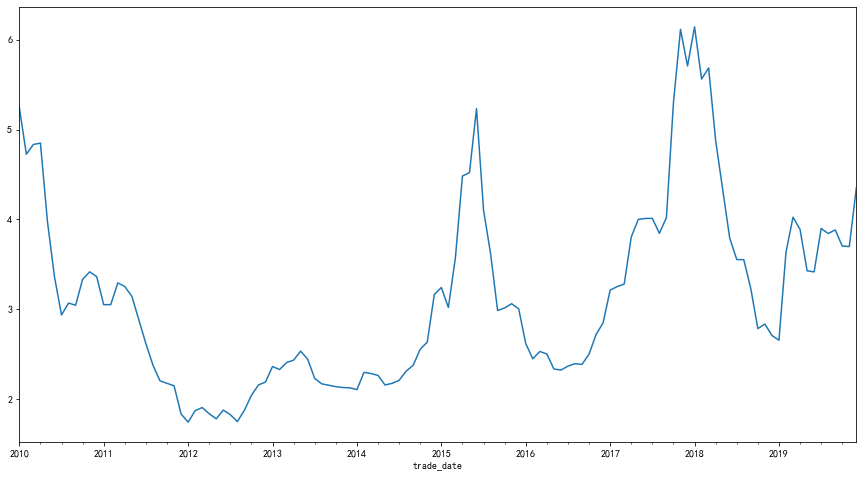

In [4]:
# 展示股票月线
df_725.to_period("M").groupby(df_725.to_period("M").index)["close"].mean().plot(figsize=(15, 8))

In [5]:
# 查看当天开盘股价无变化的日期数量
df_725[df_725["change"]==0].shape

(212, 10)

In [6]:
# 构造新列，UpOrDown：0代表跌，1代表涨
# 如果当天股价无变化，这里暂定为0
df_725.loc[df_725["change"] <= 0,'UpOrDown'] = 0
df_725.loc[df_725["change"] > 0,'UpOrDown'] = 1
# 将没用的列删除
df_725_UpOrDown = df_725[["UpOrDown"]]
df_725_UpOrDown.head()

,UpOrDown
trade_date,
2019-12-27,0.0
2019-12-26,1.0
2019-12-25,1.0
2019-12-24,1.0
2019-12-23,0.0


# 读取股民发帖数据

In [7]:
# 从数据库获取文本数据
conn = pymysql.connect(host = "localhost",user = "root",passwd = "mysql",db = "mydata",charset="utf8")
sql_query = 'SELECT * FROM jdf_detail'
df = pd.read_sql(sql_query, con=conn)
print(df.shape)
conn.close()  #使用完后记得关掉

(684416, 12)


In [8]:
df.head()

,id,list_id,用户名,用户id,时间和客户端,发帖时间,客户端名称,标题,内容,来源,更新时间,创建时间
0,199,173243,财经评论,9313013693864916,发表于 2019-12-28 09:07:36 股吧网页版,2019-12-28 09:07:36,股吧网页版,新证券法明年3月1日起施行！全面推行注册制、加大违法成本 七大要点看过来,12月28日上午，十三届全国人大常委会第十五次会议全体会议审议通过了新修订的证券法。修订后的...,"http://guba.eastmoney.com/news,cjpl,894749996....",2019-12-29 14:14:03,2019-12-29 14:14:03
1,200,173244,财经评论,9313013693864916,发表于 2019-12-27 21:58:54 股吧网页版,2019-12-27 21:58:54,股吧网页版,超预期！新三板投资门槛全面下调 150万股民将跑步进场,2019年的最后一个周五下午，新三板市场迎来了最激动人心的时刻，深化改革真正落锤。,"http://guba.eastmoney.com/news,cjpl,894725732....",2019-12-29 14:14:03,2019-12-29 14:14:03
2,201,173245,财经评论,9313013693864916,发表于 2019-12-28 09:08:22 股吧网页版,2019-12-28 09:08:22,股吧网页版,央行：推进存量浮动利率贷款定价基准转换为LPR利率,,"http://guba.eastmoney.com/news,cjpl,894749886....",2019-12-29 14:14:03,2019-12-29 14:14:03
3,202,173246,财经评论,9313013693864916,发表于 2019-12-28 09:36:03 股吧网页版,2019-12-28 09:36:03,股吧网页版,证券法明确全面推行注册制,证券时报记者获悉，新修订的证券法明确全面推行注册制。将发行股票应当“具有持续盈利能力”的要求...,"http://guba.eastmoney.com/news,cjpl,894751250....",2019-12-29 14:14:03,2019-12-29 14:14:03
4,203,173247,东方财富网,6712111507146464,发表于 2019-07-17 11:05:48 股吧网页版,2019-07-17 11:05:48,股吧网页版,炒股理财选东方财富证券！7×24小时股票开户，佣金低至万2.5,None,"http://guba.eastmoney.com/news,cjpl,857016161....",2019-12-29 14:14:03,2019-12-29 14:14:03


In [9]:
# 查看缺失值
df.isnull().sum(axis=0)

id              0
list_id         0
用户名        208887
用户id       214173
时间和客户端          0
发帖时间            0
客户端名称           0
标题           4881
内容          70798
来源              0
更新时间            0
创建时间            0
dtype: int64

In [10]:
# 用户名、用户id不影响分析，后续会删除
# 我们分析主要使用标题，所以可以把内容字段删除
# 在做完可视化后，可以把缺失标题的这一部分数据删除掉 
# 所以暂时先不做处理

In [11]:
# 过滤官方的帖子
df1 = df.loc[(df["用户名"] != "财经评论") & (df["用户名"] != "东方财富网") & (df["用户名"] != "京东方A资讯")]
# 将发帖时间转为时间类型
df1['发帖时间'] = df1['发帖时间'].dt.strftime('%Y-%m-%d')
df1["发帖时间"] = pd.to_datetime(df1["发帖时间"])
# 将发帖时间设置为索引
df1 = df1.set_index("发帖时间")
# 按照发帖时间将帖子排序
df1 = df1.sort_index(ascending=False)
df1.head()

,id,list_id,用户名,用户id,时间和客户端,客户端名称,标题,内容,来源,更新时间,创建时间
发帖时间,,,,,,,,,,,
2019-12-29,213,173257,十八厘米,1118054659715866,发表于 2019-12-29 00:50:50 东方财富Android版,东方财富Android版,周一给昊华能源陪葬！,周一给,"http://guba.eastmoney.com/news,000725,89479040...",2019-12-29 14:14:03,2019-12-29 14:14:03
2019-12-29,214,173258,京东方庄家是韭菜,2475035415123256,发表于 2019-12-29 00:42:08 股吧网页版,股吧网页版,这下可彻底毁了，随着时间的临近怕是欺骗不下去了！,时间回溯到11月27日！有条犄角旮旯里的消息在京东方吧里被无限放大，甚至是相对官方咨询！,"http://guba.eastmoney.com/news,000725,89479024...",2019-12-29 14:14:03,2019-12-29 14:14:03
2019-12-29,215,173259,灭霸的响指,3992094751257586,发表于 2019-12-29 00:33:16 东方财富Android版,东方财富Android版,绿油油的韭菜地呦，一眼望不到边～我愿做其中的一小颗呦，此心无悔。,绿油油的韭菜地呦，一眼望不到边～,"http://guba.eastmoney.com/news,000725,89479009...",2019-12-29 14:14:03,2019-12-29 14:14:03
2019-12-29,216,173260,珠穆朗玛3100,2078074862812068,发表于 2019-12-29 00:27:46 东方财富Android版,东方财富Android版,周一可以跌停了,周一可以跌停了,"http://guba.eastmoney.com/news,000725,89478999...",2019-12-29 14:14:03,2019-12-29 14:14:03
2019-12-28,367,173415,千年韭菜根,9919094859432214,发表于 2019-12-28 07:45:12 股吧Android版,股吧Android版,娱乐互动：‘’娱乐互动‘’[俏皮][俏皮][俏皮]严禁高举‘’标语或口号‘’~摇,娱乐互动：‘’娱乐互动‘’,"http://guba.eastmoney.com/news,000725,89474455...",2019-12-29 14:14:57,2019-12-29 14:14:57


# 发帖数据的基本可视化

In [12]:
# 可视化用户评论使用的客户端类型
# 可以看到使用网页和安卓客户端发帖的用户最多
client_count = df1.groupby("客户端名称")["id"].count().sort_values(ascending=False)
client_count

客户端名称
股吧网页版             335215
东方财富Android版      180549
东方财富电脑版            58891
东方财富iPhone版        51347
股吧手机网页版            33008
股吧Android版         12326
东方财富手机版             5165
股吧iPhone版            953
东方财富网iPad版           691
东方财富通WP版             460
东方财富网网页版             115
东方财富网手机网页版            17
东方财富期货Android版         2
天天基金手机网页版              1
Name: id, dtype: int64

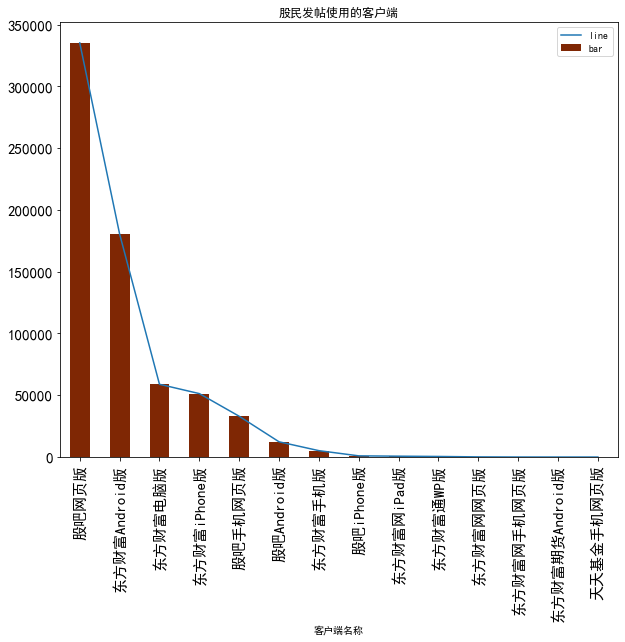

In [13]:
client_count.plot(title='股民发帖使用的客户端',label='line',legend=True, fontsize=15)
client_count.plot(kind='bar',colormap='Oranges_r',label='bar',legend=True, figsize=(10,8), fontsize=15)

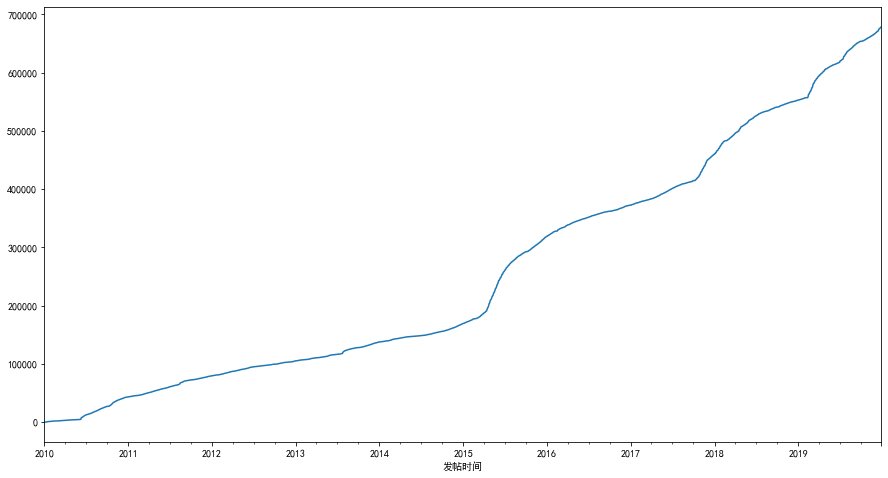

In [14]:
# 累积发帖趋势
df1[["id"]].to_period("D").groupby(df1[["id"]].to_period("D").index)["id"].count().cumsum().plot(figsize=(15, 8))

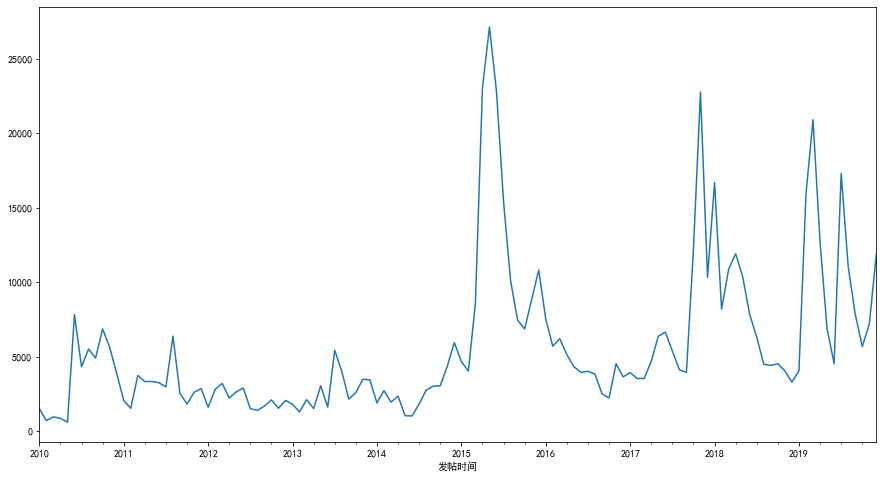

In [15]:
# 按月统计发帖量
df1[["id"]].to_period("M").groupby(df1[["id"]].to_period("M").index)["id"].count().plot(figsize=(15, 8))

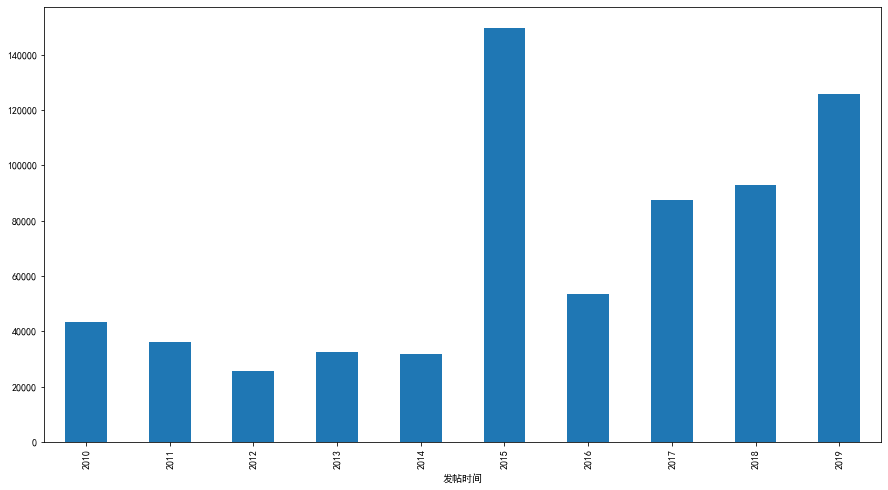

In [16]:
# 按年统计发帖量
df1[["id"]].to_period("Y").groupby(df1[["id"]].to_period("Y").index)["id"].count().plot.bar(figsize=(15, 8))

# 数据预处理

In [17]:
# 只保留标题列
df2 = df1[["标题"]]
# 去掉缺失值
print("删除前：", df2.shape)
df2 = df2.dropna()
print("删除后：", df2.shape)
df2.head()

删除前： (678740, 1)
删除后： (673859, 1)


,标题
发帖时间,
2019-12-29,周一给昊华能源陪葬！
2019-12-29,这下可彻底毁了，随着时间的临近怕是欺骗不下去了！
2019-12-29,绿油油的韭菜地呦，一眼望不到边～我愿做其中的一小颗呦，此心无悔。
2019-12-29,周一可以跌停了
2019-12-28,娱乐互动：‘’娱乐互动‘’[俏皮][俏皮][俏皮]严禁高举‘’标语或口号‘’~摇


In [18]:
# 增加标题的长度
df2["len"] = df2["标题"].apply(len)
df2.head()

,标题,len
发帖时间,,
2019-12-29,周一给昊华能源陪葬！,10
2019-12-29,这下可彻底毁了，随着时间的临近怕是欺骗不下去了！,24
2019-12-29,绿油油的韭菜地呦，一眼望不到边～我愿做其中的一小颗呦，此心无悔。,32
2019-12-29,周一可以跌停了,7
2019-12-28,娱乐互动：‘’娱乐互动‘’[俏皮][俏皮][俏皮]严禁高举‘’标语或口号‘’~摇,40


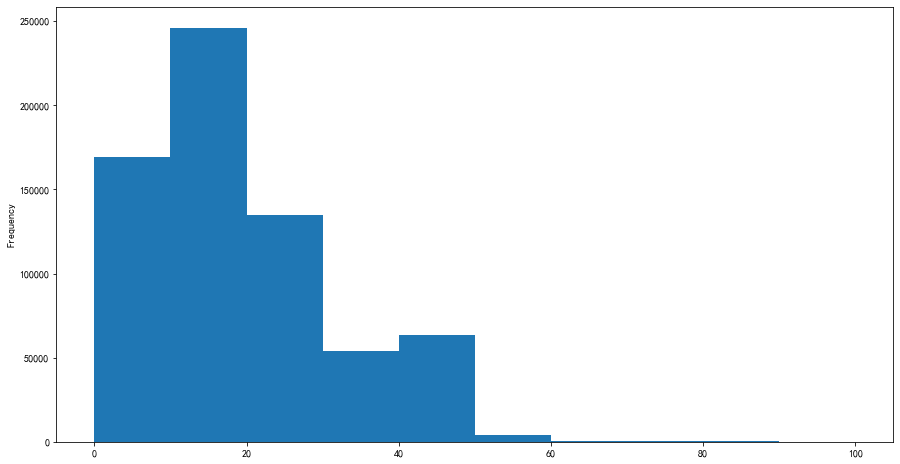

In [19]:
# 标题长度分布
df2["len"].plot.hist(figsize=(15, 8))

In [20]:
# 每个帖子增加一个特殊符号
df2["标题"] = df2["标题"] + "\t"
# 按照发帖时间将帖子内容拼接起来
df2grp = df2[["标题"]].groupby(df2.index).sum()
print("按照日期拼接后：", df2grp.shape)
# 构造新列：当日帖子总长度
df2grp["len"] = df2grp["标题"].apply(len)
# 按照时间排序
df2grp = df2grp.sort_index(ascending=False)
df2grp.head(10)

按照日期拼接后： (3649, 1)


,标题,len
发帖时间,,
2019-12-29,周一给昊华能源陪葬！\t这下可彻底毁了，随着时间的临近怕是欺骗不下去了！\t绿油油的韭菜地呦...,77
2019-12-28,娱乐互动：‘’娱乐互动‘’[俏皮][俏皮][俏皮]严禁高举‘’标语或口号‘’~摇\t本月连出...,3743
2019-12-27,什么原因停牌\t已出了五个多亿了，低于3.7严重破位下跌大家快跑吧\t京东方作为最大最出名的...,13617
2019-12-26,酝酿情绪，准备一飞冲天\t撤退，不撤退不行了，假突破\t4.88成交，棒棒哒\t出货速度真快...,14381
2019-12-25,高位久盘必跌\t快乐：其实‘’韭菜根‘’股市投资~赚多少钱都无所谓~因‘’韭菜根‘’股市投资...,8984
2019-12-24,妈的，每次买这个股票都是当接盘侠\t成分B指屌炸天，大伙别慌\t129万股东，剧减！\t懂得...,10183
2019-12-23,外资会是京东方股市中的董垂瑞吗\t京东方本周上5元同意吗？[赞][赞][赞]\t感觉人生已经...,10721
2019-12-22,微笑着，我来了，看一眼，我走了\t转发\t笑迎2020：远离~分析(别人主给出的)[俏皮][...,3087
2019-12-21,周一跌停我满仓进\t2月20日消息，在第二届崇礼论坛上，百度创始人、董事长兼CEO李彦宏发表...,2943


In [21]:
# 按照索引（时间）合并语料和涨跌
condf = df2grp.join(df_725_UpOrDown)
print(condf.shape)
condf.isnull().sum(axis=0)

(3649, 3)


标题             0
len            0
UpOrDown    1236
dtype: int64

In [22]:
# 语料的发布日期中有很多不是开盘的日期，所以我们将缺失涨跌数据的这些数据删除
condf = condf.dropna()
print(condf.shape)
condf.head()

(2413, 3)


,标题,len,UpOrDown
发帖时间,,,
2019-12-27,什么原因停牌\t已出了五个多亿了，低于3.7严重破位下跌大家快跑吧\t京东方作为最大最出名的...,13617,0.0
2019-12-26,酝酿情绪，准备一飞冲天\t撤退，不撤退不行了，假突破\t4.88成交，棒棒哒\t出货速度真快...,14381,1.0
2019-12-25,高位久盘必跌\t快乐：其实‘’韭菜根‘’股市投资~赚多少钱都无所谓~因‘’韭菜根‘’股市投资...,8984,1.0
2019-12-24,妈的，每次买这个股票都是当接盘侠\t成分B指屌炸天，大伙别慌\t129万股东，剧减！\t懂得...,10183,1.0
2019-12-23,外资会是京东方股市中的董垂瑞吗\t京东方本周上5元同意吗？[赞][赞][赞]\t感觉人生已经...,10721,0.0


In [23]:
# 停用词列表
stoplist = ["\t"]

# 分词函数，这里保留了标点符号
def xh_cut(intxt):
    return " ".join([w for w in jieba.cut(intxt) if w not in stoplist])

# 将语料分词
condf["cut"] = condf["标题"].apply(xh_cut)
condf.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wq/03z5h7352159jp2k5p83ts500000gn/T/jieba.cache
Loading model cost 0.776 seconds.
Prefix dict has been built successfully.


,标题,len,UpOrDown,cut
发帖时间,,,,
2019-12-27,什么原因停牌\t已出了五个多亿了，低于3.7严重破位下跌大家快跑吧\t京东方作为最大最出名的...,13617,0.0,什么 原因 停牌 已出 了 五个 多亿 了 ， 低于 3.7 严重 破位 下跌 大家 快 跑...
2019-12-26,酝酿情绪，准备一飞冲天\t撤退，不撤退不行了，假突破\t4.88成交，棒棒哒\t出货速度真快...,14381,1.0,酝酿 情绪 ， 准备 一飞冲天 撤退 ， 不 撤退 不行 了 ， 假 突破 4.88 成交 ...
2019-12-25,高位久盘必跌\t快乐：其实‘’韭菜根‘’股市投资~赚多少钱都无所谓~因‘’韭菜根‘’股市投资...,8984,1.0,高位 久盘 必跌 快乐 ： 其实 ‘ ’ 韭菜 根 ‘ ’ 股市 投资 ~ 赚 多少 钱 都...
2019-12-24,妈的，每次买这个股票都是当接盘侠\t成分B指屌炸天，大伙别慌\t129万股东，剧减！\t懂得...,10183,1.0,妈 的 ， 每次 买 这个 股票 都 是 当 接盘 侠 成分 B 指 屌 炸天 ， 大伙 别...
2019-12-23,外资会是京东方股市中的董垂瑞吗\t京东方本周上5元同意吗？[赞][赞][赞]\t感觉人生已经...,10721,0.0,外资 会 是 京东方 股市 中 的 董垂瑞 吗 京东方 本周 上 5 元 同意 吗 ？ [ ...


In [24]:
# 字体
myfont = "/Users/nick/Desktop/project/0data/a/SimHei.ttf"
# 停用词路径
stoplistdf = pd.read_csv('停用词.txt', names=["w"], sep="aaa", encoding="utf-8")
stoplist_wdc = list(stoplistdf.w) + stoplist

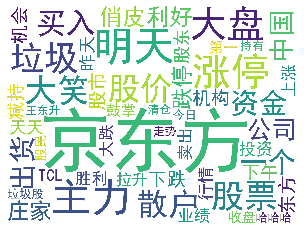

In [25]:
# 词云 将所有的帖子进行分词，统计词频，展示词云
gennerate_string = ""
for c in condf["cut"]:
    gennerate_string += c

# 生成词云对象
cloudobj = wordcloud.WordCloud(font_path = myfont, 
    width = 2000, height = 1500, max_words = 50,
    mode = "RGBA", background_color = None,
    stopwords = stoplist_wdc, collocations=False).generate(gennerate_string)  

plt.imshow(cloudobj)
plt.axis("off")
plt.show()

# 文本向量化

## 词袋模型-矩阵

In [26]:
# 词袋模型-矩阵
vect = CountVectorizer()
wordmtx = vect.fit_transform(condf["cut"])
print(wordmtx.shape)
# print(wordmtx)

(2413, 128162)


## tfidf-矩阵

In [27]:
# tfidf-矩阵
transf = TfidfTransformer()
tfidf = transf.fit_transform(wordmtx)
# print(tfidf)
print(tfidf.todense().shape)
# print(vect.vocabulary_)

(2413, 128162)


## word2vec表示

In [28]:
def cut_split(txt):
    return txt.split(" ")

# word2vec矩阵表示文本
condf["cut_list"] = condf["cut"].apply(cut_split)
w2vmodel = Word2Vec(size=300, min_count=5)
w2vmodel.build_vocab(condf["cut_list"])  # 生成词
# 训练word2vec模型
%time w2vmodel.train(condf["cut_list"], total_examples=w2vmodel.corpus_count, epochs=10)

CPU times: user 2min 13s, sys: 597 ms, total: 2min 13s
Wall time: 46 s


(51399891, 69092890)

In [29]:
# 分析“涨停"的相似词
w2vmodel.wv.most_similar("涨停", topn=5)

[('涨停板', 0.7064339518547058),
 ('一字板', 0.6698480248451233),
 ('跌停', 0.6464972496032715),
 ('封板', 0.6299799680709839),
 ('涨板', 0.6203790903091431)]

In [30]:
# 分析“跌停"的相似词
w2vmodel.wv.most_similar("跌停", topn=5)

[('跌停板', 0.6756128072738647),
 ('涨停', 0.6464971899986267),
 ('一字板', 0.512378990650177),
 ('补跌', 0.5061174631118774),
 ('破四', 0.49450135231018066)]

In [31]:
# 分析“投资"的相似词
w2vmodel.wv.most_similar("投资", topn=5)

[('内在', 0.6386024951934814),
 ('重估', 0.5839271545410156),
 ('长期投资', 0.5561195611953735),
 ('评估', 0.5343352556228638),
 ('投資', 0.5218364000320435)]

In [32]:
# 分析“散户"的相似词
w2vmodel.wv.most_similar("散户", topn=5)

[('小散', 0.7885055541992188),
 ('散民', 0.5454227924346924),
 ('散们', 0.5252149105072021),
 ('小散们', 0.5030875205993652),
 ('小股民', 0.4992014169692993)]

In [33]:
# 用各个词向量直接平均的方式生成整句对应的向量
def m_avgvec(words, w2vmodel):
    global count
    if count % 300 == 0:
        print("\r{}/{}".format(count, rows_count))
    count += 1
    return pd.DataFrame([w2vmodel.wv[w] for w in words if w in w2vmodel.wv]).agg("mean")

# 生成建模用矩阵，耗时较长
count = 1
rows_count = condf.shape[0]
%time train_vecs = pd.DataFrame([m_avgvec(s, w2vmodel) for s in condf["cut_list"]])
train_vecs.head()

300/2413
600/2413
900/2413
1200/2413
1500/2413
1800/2413
2100/2413
2400/2413
CPU times: user 8min 13s, sys: 29.9 s, total: 8min 43s
Wall time: 8min 44s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.014316,-0.007375,-0.014319,0.072762,-0.112406,0.044476,0.117199,-0.096944,-0.109896,0.107267,...,-0.025740,-0.080778,-0.136578,0.063904,0.349477,0.487742,0.034895,-0.093307,-0.055363,0.048256
1,0.017274,-0.011791,-0.007729,0.113607,-0.182851,0.050373,0.089974,0.002026,-0.045980,0.111897,...,-0.000136,-0.122330,-0.174073,0.052100,0.351771,0.511932,0.047220,-0.068674,-0.121643,0.072002
2,0.035825,-0.047902,0.033487,0.142451,-0.223405,0.046358,0.022808,0.010509,-0.017365,0.144191,...,0.066783,-0.141873,-0.231437,0.051754,0.305208,0.480038,0.067792,-0.065750,-0.191465,0.130742
3,-0.006406,-0.047310,0.011010,0.075867,-0.086596,0.033657,0.131798,-0.048646,-0.084177,0.077796,...,-0.022681,-0.114743,-0.164883,0.020262,0.332615,0.465340,0.039235,-0.107839,-0.051055,0.034373
4,0.013347,-0.009760,0.024558,0.088814,-0.174580,0.018972,0.089989,-0.037146,-0.087608,0.118609,...,-0.003226,-0.113286,-0.171068,0.051803,0.378839,0.534160,0.018596,-0.068930,-0.097445,0.069949


# 建模

In [34]:
# 用来储存建模的量化指标
items = []

## 训练SVM模型

In [35]:
# 词袋模型-SVM建模
x_train, x_test, y_train, y_test = train_test_split(wordmtx, condf["UpOrDown"], test_size=0.3, random_state=30)
model = SVC(kernel = 'rbf', verbose = True)
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

item = {
    "向量化": "词袋模型",
    "算法": "SVM",
    "训练集": train_score,
    "测试集": test_score,
}
items.append(item)
print("【词袋模型-SVM建模】train_score: {} test_score: {}".format(train_score, test_score))

[LibSVM]【词袋模型-SVM建模】train_score: 0.6210775606867969 test_score: 0.649171270718232


In [36]:
# tfidf-SVM建模
x_train, x_test, y_train, y_test = train_test_split(tfidf, condf["UpOrDown"], test_size=0.3, random_state=30)
model = SVC(kernel = 'rbf', verbose = True)
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)
item = {
    "向量化": "tfidf",
    "算法": "SVM",
    "训练集": train_score,
    "测试集": test_score
}
items.append(item)
print("【tfidf-SVM建模】train_score: {} test_score: {}".format(train_score, test_score))

[LibSVM]【tfidf-SVM建模】train_score: 0.5488454706927176 test_score: 0.585635359116022


In [37]:
# word2vec-SVM建模
x_train, x_test, y_train, y_test = train_test_split(train_vecs, condf["UpOrDown"], test_size=0.3, random_state=30)
model = SVC(kernel = 'rbf', verbose = True)
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)
item = {
    "向量化": "word2vec",
    "算法": "SVM",
    "训练集": train_score,
    "测试集": test_score
}
items.append(item)
print("【word2vect-SVM建模】train_score: {} test_score: {}".format(train_score, test_score))

[LibSVM]【word2vect-SVM建模】train_score: 0.5494375370041444 test_score: 0.5870165745856354


## 训练朴素贝叶斯模型

In [38]:
# 词袋模型-朴素贝叶斯
x_train, x_test, y_train, y_test = train_test_split(wordmtx, condf["UpOrDown"], test_size=0.3, random_state=30)
nbmodel = naive_bayes.MultinomialNB()
nbmodel.fit(x_train, y_train)
# 预测
y_predict = nbmodel.predict(x_test)
# 预测准确率
train_score = nbmodel.score(x_train, y_train)
test_score = nbmodel.score(x_test, y_test)
item = {
    "向量化": "词袋模型",
    "算法": "朴素贝叶斯",
    "训练集": train_score,
    "测试集": test_score
}
items.append(item)
print("【词袋模型-朴素贝叶斯】train_score: {} test_score: {}".format(train_score, test_score))

【词袋模型-朴素贝叶斯】train_score: 0.9887507400828893 test_score: 0.680939226519337


In [39]:
y_prob = nbmodel.predict_proba(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("** auc_value: 【{}】 **".format(auc_value))

** auc_value: 【0.7236556603773585】 **


In [40]:
# tfidf-朴素贝叶斯
x_train, x_test, y_train, y_test = train_test_split(tfidf, condf["UpOrDown"], test_size=0.3, random_state=30)
nbmodel = naive_bayes.MultinomialNB()
nbmodel.fit(x_train, y_train)
# 预测
y_predict = nbmodel.predict(x_test)
# 预测准确率
train_score = nbmodel.score(x_train, y_train)
test_score = nbmodel.score(x_test, y_test)
item = {
    "向量化": "tfidf",
    "算法": "朴素贝叶斯",
    "训练集": train_score,
    "测试集": test_score
}
items.append(item)
print("【tfidf-朴素贝叶斯】train_score: {} test_score: {}".format(train_score, test_score))

【tfidf-朴素贝叶斯】train_score: 0.5595026642984015 test_score: 0.585635359116022


In [ ]:
y_prob = nbmodel.predict_proba(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("** auc_value: 【{}】 **".format(auc_value))

In [41]:
# word2vec-朴素贝叶斯
x_train, x_test, y_train, y_test = train_test_split(train_vecs, condf["UpOrDown"], test_size=0.3, random_state=30)
nbmodel = naive_bayes.GaussianNB()
nbmodel.fit(x_train, y_train)
# 预测
y_predict = nbmodel.predict(x_test)
# 预测准确率
train_score = nbmodel.score(x_train, y_train)
test_score = nbmodel.score(x_test, y_test)
item = {
    "向量化": "word2vec",
    "算法": "朴素贝叶斯",
    "训练集": train_score,
    "测试集": test_score
}
items.append(item)
print("【word2vec-朴素贝叶斯】train_score: {} test_score: {}".format(train_score, test_score))

【word2vec-朴素贝叶斯】train_score: 0.6471284783895797 test_score: 0.6243093922651933


In [42]:
pd.DataFrame(items, columns=["向量化", "算法", "训练集", "测试集"])

,向量化,算法,训练集,测试集
0,词袋模型,SVM,0.621078,0.649171
1,tfidf,SVM,0.548845,0.585635
2,word2vec,SVM,0.549438,0.587017
3,词袋模型,朴素贝叶斯,0.988751,0.680939
4,tfidf,朴素贝叶斯,0.559503,0.585635
5,word2vec,朴素贝叶斯,0.647128,0.624309
